# 2章　自然言語と単語の分散表現

単語の意味をコンピューターに授ける手法

・シソーラスによる手法
・カウントベースの手法
・推論ベースの手法(word2vec)

### シソーラス

人手によって定義する手法。

類語辞書であり、「同義語」や「類義語」が同じグループに分類。

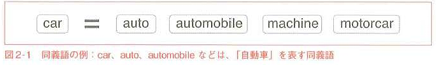

単語の間で「上位と下位」、「全体と部分」などの関連性が定義されている場合がある。

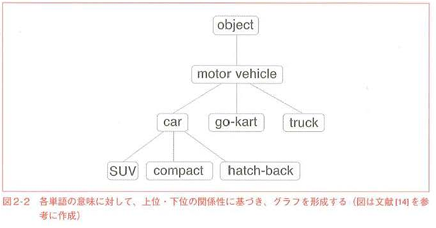

もっとも有名なシソーラスは“WordNet”

類義語を取得したり、“単語ネットワーク”を利用したりできる。

また、単語ネットワークを使って単語間の類似度を算出することも可能。

問題点

・時代の変化に対応するのが困難
・人の作業コストが高い
・単語の細かなニュアンスが表現できない

### カウントベースの手法

人の手によって書かれた、大量のテキストデータである“コーパス”を利用。

人の知識が詰まったコーパスから、自動的に、そして効率良く、そのエッセンスを抽出する。

WikipediaゃGoogleNewsなどのテキストデータ、シェイクスピアや夏目漱石など、倅大な作家の作品群もコーパスとして利用される。

**1文からなる単純なテキストをコーパスとして利用**

In [2]:
text = 'you say goodby and I say hello.'

前処理を行う

In [3]:
text = text.lower()           #すべての文字を小文字に変換
text = text.replace('.',' .') #ピリオドの前にスペースを挿入
text

'you say goodby and i say hello .'

In [4]:
words = text.split(' ')   #スペースを 「区切り文字」として分割
words

['you', 'say', 'goodby', 'and', 'i', 'say', 'hello', '.']

単語のIDと単語の対応表

In [5]:
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [6]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodby', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [7]:
word_to_id

{'you': 0, 'say': 1, 'goodby': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [8]:
id_to_word[1]

'say'

In [9]:
word_to_id['hello']

5

「単語のリスト」を「単語のIDのリスト」に変換

In [10]:
import numpy as np
corpus = [word_to_id [w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [11]:
def preprocess (text) :
    text = text. lower ()
    text = text. replace ('.' ,' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id [w] for w in words])

    return corpus, word_to_id, id_to_word

In [12]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
corpus, word_to_id, id_to_word

(array([0, 1, 2, 3, 4, 1, 5, 6]),
 {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6},
 {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'})

単語をベクトルで表す＝単語の分散表現

「単語の意味は、周囲の単語によって形成される」という“分布仮説”に基づいて行われる。

「コンテキスト」とは、ある中央の単語に対して、その周囲にある単語を指す。

コンテキストのサイズをウィンドウサイズという。

ウィンドウサイズが1の場合は左右の1単語、ウィンドウサイズが2の場合は左右の2単語

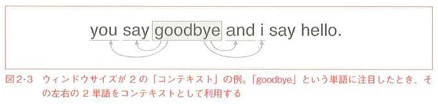

周囲の単語をカウントすることで単語をベクトルで表す

下準備

In [13]:
text = 'you say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print (corpus,id_to_word)

[0 1 2 3 4 1 5 6] {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


ウィンドウサイズ1として、単語IDが0の「you」からそのコンテキストに含まれる単語の頻度を数えていく。

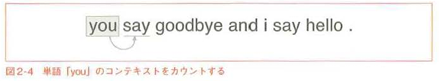

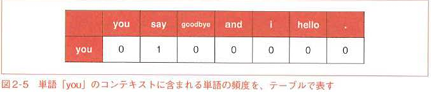

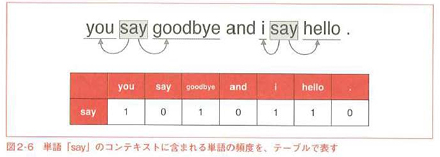

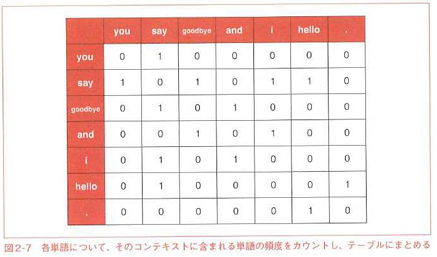

すべての単語に対して、共起する単語をテーブルにまとめたもの、共起行列と呼ぶ。

各行が、該当する単語のベクトルに対応する。

In [14]:
C = np.array([
    [0, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 1, 1, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 0],
], dtype=np.int32)

In [15]:
print(C[0])

[0 1 0 0 0 0 0]


In [16]:
print(C[word_to_id['goodbye']])

[0 1 0 1 0 0 0]


コーパスから共起行列を作る関数の実装

In [17]:
def create_co_matrix(corpus, vocab_size, window_size=1) :
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)  #co_matrixを要素が0の2次元配列で初期化
    for idx,word_id in enumerate(corpus):            #enumerate(corpus) は、corpusの各単語IDとそのインデックス（位置）を同時に取得
        for i in range (1, window_size + 1):
            left_idx = idx - i                       #ターゲット単語の左側i番目の単語のインデックス
            right_idx = idx + i                      #ターゲット単語の右側i番目の単語のインデックス

        if left_idx >= 0:       #コーパスの範囲内であることを確認
            left_word_id = corpus[left_idx]
            co_matrix[word_id, left_word_id] += 1     #該当する位置の値を1増やす

        if right_idx < corpus_size:
            right_word_id = corpus[right_idx]
            co_matrix[word_id, right_word_id] += 1

    return co_matrix

ベクトル間の類似度を計測するためにコサイン類似度を用いる。

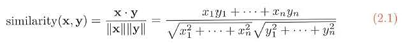

2つのベクトルが完全に同じ方向を向いているとき1になり、逆向きだと―1になる。

In [18]:
def cos_similarity(x, y, eps=1e-8):   #eps=10^-8を指定して、“O除算＂が発生してしまうこと防ぐ
    nx = (x / np.sqrt(np.sum(x ** 2)) + eps)  # xの正規化
    ny = (y / np.sqrt(np.sum(y ** 2)) + eps)  # yの正規化
    return np.dot(nx, ny)

「you」と「I」の類似度

In [19]:
text ='You say goodbye and I say hello,'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
c0 = C[word_to_id['you']]    #「you」の単語ペクトル
c1 = C[word_to_id['i']]      #「i」の 単語ペクトル
print(cos_similarity(c0, c1))

0.7071068053286838


ある単語がクエリとして与えられたときに、そのクエリに対して類似した単語を上位から順に表示する関数

In [20]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''類似単語の検索
    :param query: クエリ（テキスト）
    :param word_to_id: 単語から単語IDへのディクショナリ
    :param id_to_word: 単語IDから単語へのディクショナリ
    :param word_matrix: 単語ベクトルをまとめた行列。各行に対応する単語のベクトルが格納されていることを想定する
    :param top: 上位何位まで表示するか
    '''
    if query not in word_to_id:
        print('%s is not found' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    count = 0
    for i in (-1 * similarity).argsort():   # argsort()メソッドは、NumPy配列の要素を小さい順にソート
                                            # そのため、マイナスをかけた後で利用
        if id_to_word[i] == query:    #クエリ単語が結果として表示されないようにスキップ
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

In [21]:
text ='You say goodbye and I say hello '
corpus, word_to_id, id_to_word = preprocess (text)
vocab_size = len(word_to_id)
C = create_co_matrix (corpus, vocab_size)
most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071068053286839
 hello: 0.7071068053286839
 i: 0.7071068053286839
 say: 3.00000007e-08
 and: 2.4142136323730946e-08


「car」は「drive」よりも高頻度な単語である「the」の方に強い相関を持ってしまう。

この問題を解決するために相合情報量（PMI）と呼ばれる指標が使われる。

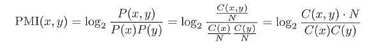

単語xとyの共起する回数をC(x,y)、単語x,yの出現する回数はそれぞれC(x),C(y)、コーパスに含まれる単語数をNとする。

コーバス中の単語数を10,000 として、「the」が1,000 回、「car」が20回「drive」が10回出現、「the」と「car」の共起が10回、「car」と「drive」の共起が5回のとき

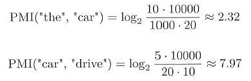

2つの単語で共起する回数が0の場合、$log_20=-∞$となってしまうため、実践上では正の相互情報量（PPMI）が使われる。

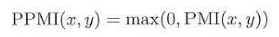

共起行列をPPMI行列に変換する関数を実装

In [22]:
def ppmi(C, verbose=False, eps = 1e-8):
    '''PPMI（正の相互情報量）の作成
    :param C: 共起行列
    :param verbose: 進行状況を出力するかどうか
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)                   #コーパス全体の単語の総数
    S = np.sum(C, axis=0)           #各単語の出現回数
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100 + 1) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M

In [23]:
text ='You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3) #有効桁3桁で表示
print('covariance matrix')
print(C)
print('-'*58)
print('PPMI' )
print(W)

covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
----------------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


コーパスの語彙数が増えるにつれて、各単語のべクトルの次元数も増えていくため、ベクトルの次元を削減する。

また、行列の多くの要素が0であり、各要素の持つ
”重要度”は低い。
そのようなベクトルはノイズに弱く、頑健性に乏しい。

 "重要な情報”をできるだけ残した上で削減するために、新たな軸を導入する。

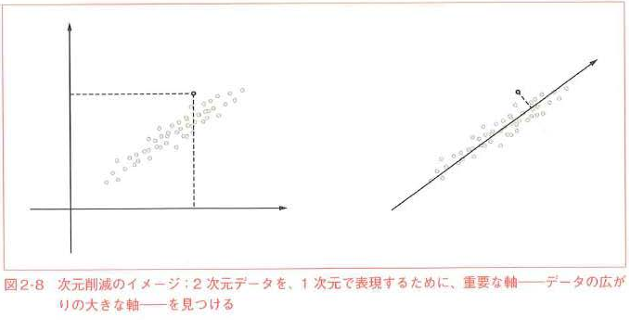

任意の行列を3つの行列の積へと分解する、特異値分解 (SYD) を使った次元削減を行う。

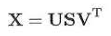

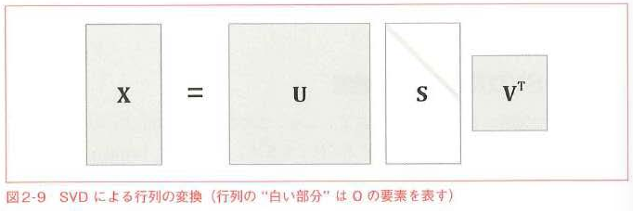

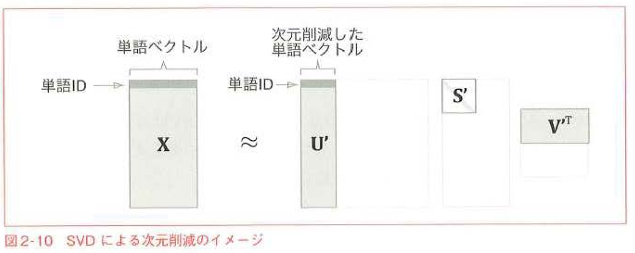

Sは対角行列で、この対角成分には、「特異値」が大きい順に並んでおり、特異値が小さいものは重要度が低いので、行列Uから余分な列ベクトルを削ることで、元の行列を近似することができる。

SVDを実行

In [25]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix (corpus, vocab_size, window_size=1)
W = ppmi(C)
# SVD
U, S, V = np.linalg.svd(W)

In [26]:
print(C[0])

[0 1 0 0 0 0 0]


In [27]:
print(W[0])

[0.    1.807 0.    0.    0.    0.    0.   ]


In [29]:
print(U[0])

[ 3.409e-01 -1.110e-16 -1.205e-01 -4.163e-16 -9.323e-01 -1.110e-16
 -2.426e-17]


In [30]:
print(U[0, :2])     #2次元のベクトルに削減

[ 3.409e-01 -1.110e-16]


各単語を2次元のベクトルで表し、それをグラフにプロット

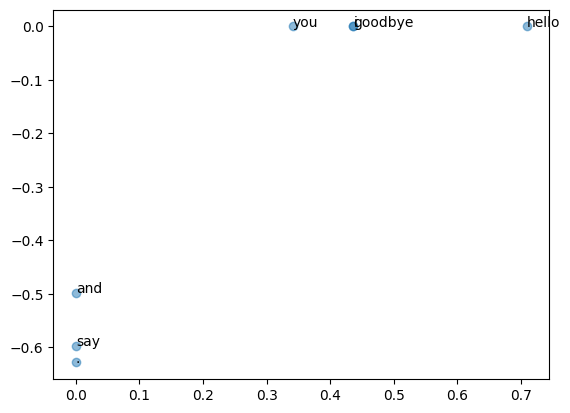

In [32]:
import matplotlib.pyplot as plt
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

「goodbye」と「hello」、「you」と 「i」が近い場所に位置する

PTB(Penn Treebank)と呼ばれるコーパスを利用する。

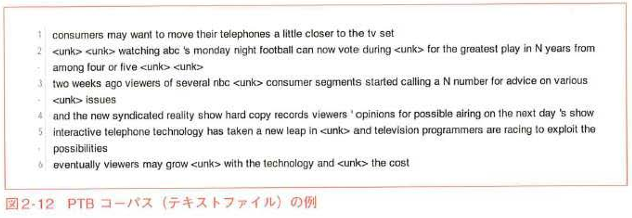

In [34]:
import sys
sys.path.append ('..')
import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')

print('corpus size:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

Done
corpus size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


In [37]:
window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('counting  co-occurrence ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('calculating PPMI ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try:
    # 乱数を使ったTruncated SVDで、特異値の大きいものだけに
    # 限定して計算することで、通常のSVDよりも高速な計算が行える
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except ImportError:
    # SVD (slow)
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

counting  co-occurrence ...
calculating PPMI ...
1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.0% done
56.0% done
57.0% done
58.0% done
59.0% done
60.0% done
61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% done
73.0% done
74.0% done
75.0% done
76.0% done
77.0% done
78.0% done
79.0% done
80.0% done
81.0% done
82.0% done
83.0% done
84.0% done
85.0% done
86.0% done
87.0% done
88.

単語の意味的な点と文法的な点において、
似た単語どうしが近いベクトルで表される。